In [36]:
import sqlite3
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd

In [37]:
date = ''

In [38]:
module_3db_filename = 'dinofunworld.db'
connection = sqlite3.connect(module_3db_filename)
cursor = connection.cursor()


def execute_query(query: str) -> str:
    formatted_date = f"'{date}%'"
    formatted_query = query.format(formatted_date)
    return cursor.execute(formatted_query).fetchall()

A Distance matrix for calculating the difference between the routes of visitors. Each route includes a sequence with 5-minute intervals. The calculation result shows the number of time intervals that do not coincide between two visitors, that is, how different their routes were.

In [39]:
visitor_ids = ('165316', '1835254', '296394', '404385', '448990')
distance_matrix_data_query = f"""
SELECT *
FROM Sequences
WHERE visitorID IN {visitor_ids}
"""

distance_matrix_data = execute_query(distance_matrix_data_query)

visitor_sequence_dict = {}
for item in distance_matrix_data:
    visitor_sequence_dict[item[1]] = item[2]

result_dict = {
    visitor: {
        other_visitor: 0 for other_visitor in visitor_sequence_dict
    } for visitor in visitor_sequence_dict
}

for visitor_a in visitor_sequence_dict:
    for visitor_b in visitor_sequence_dict.keys():
        result_dict[visitor_a][visitor_b] = 0
        if visitor_a == visitor_b:
            continue

        seq_a = visitor_sequence_dict[visitor_a].split("-")
        seq_b = visitor_sequence_dict[visitor_b].split("-")

        result_dict[visitor_a][visitor_b] = sum(1 for part_a, part_b in zip(seq_a, seq_b) if part_a != part_b)

print(result_dict)

{165316: {165316: 0, 296394: 318, 404385: 329, 448990: 318, 1835254: 336}, 296394: {165316: 318, 296394: 0, 404385: 303, 448990: 0, 1835254: 282}, 404385: {165316: 329, 296394: 303, 404385: 0, 448990: 303, 1835254: 298}, 448990: {165316: 318, 296394: 0, 404385: 303, 448990: 0, 1835254: 282}, 1835254: {165316: 336, 296394: 282, 404385: 298, 448990: 282, 1835254: 0}}


A Parallel Coordinate Plot based on the next calculation: We iterate through 5 minutes of time slots, find the number of visits to each attraction within the slot, and add them up. Based on this information, we look for the minimum, maximum, and average values for each attraction separately.

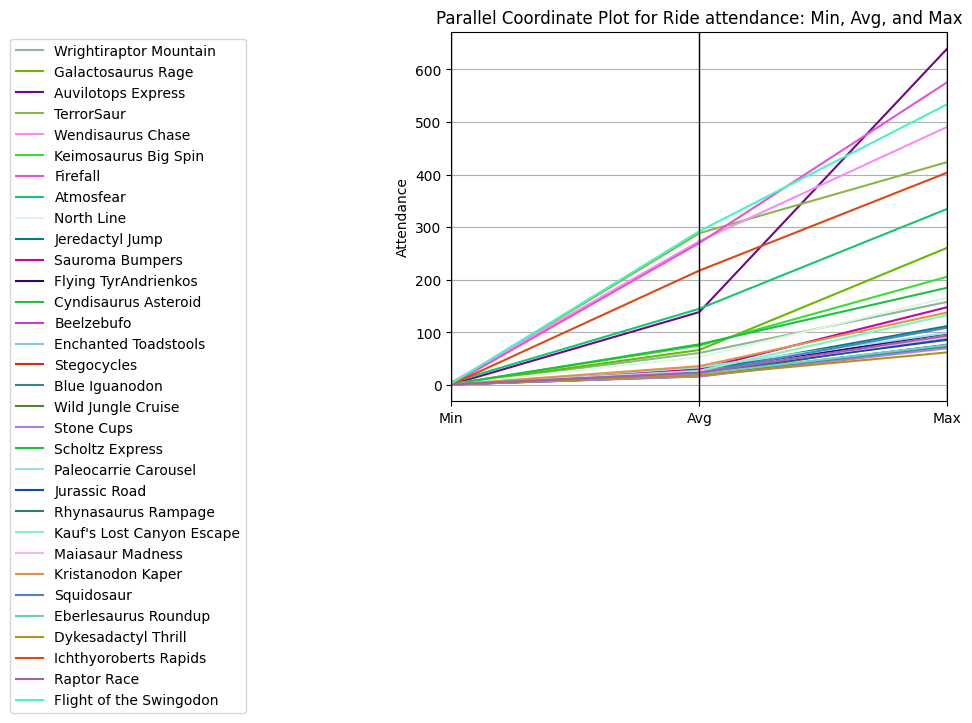

In [40]:
attraction_data_query = """
SELECT AttractionID, Attraction.Name
FROM Attraction
WHERE Attraction.Category LIKE '%Ride%'
GROUP BY AttractionID
"""

sequences_data_query = """
SELECT Sequences.visitorID, Sequences.sequence
FROM Sequences
"""

attraction_data = execute_query(attraction_data_query)
sequences_data = execute_query(sequences_data_query)

sequences_df = pd.DataFrame.from_records(sequences_data, columns=['visitorID', 'sequence'])
sequences_df['sequence'] = sequences_df['sequence'].apply(lambda data: [seq for seq in data.split("-")])

attraction_ids = [i[0] for i in attraction_data]
attraction_names = [i[1] for i in attraction_data]

result_list = []

sequence_col = sequences_df['sequence'].values
for i, attraction_id in enumerate(attraction_ids):
    sequence_new = [[1 if j == str(attraction_id) else 0 for j in v] for v in sequence_col]
    visitor_cnt = np.sum(sequence_new, axis=0)
    visitor_cnt = visitor_cnt[visitor_cnt > 0]
    min_cnt = np.min(visitor_cnt)
    max_cnt = np.max(visitor_cnt)
    avg_cnt = np.mean(visitor_cnt)
    result_list.append([attraction_names[i], min_cnt, avg_cnt, max_cnt])

df = pd.DataFrame(result_list, columns=['Name', 'Min', 'Avg', 'Max'])
pd.plotting.parallel_coordinates(df, 'Name')
plt.gca().legend(bbox_to_anchor=(-0.4, 1), loc='upper right')
plt.title('Parallel Coordinate Plot for Ride attendance: Min, Avg, and Max')
plt.ylabel('Attendance')
plt.show()

The same data as for the previous task but represented using a Scatter plot Matrix

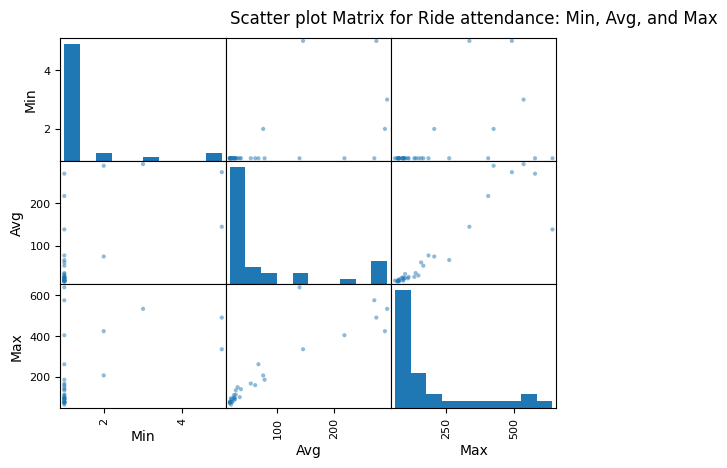

In [41]:
pd.plotting.scatter_matrix(df)
plt.title('Scatter plot Matrix for Ride attendance: Min, Avg, and Max', y=3.05)
plt.show()